# Modelo de clusterizacion DBSCAN

## Importar librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons # datos de prueba
from sklearn.cluster import DBSCAN  # modelo DBSCAN
from sklearn.metrics import silhouette_score

## Preparando datos de prueba

In [3]:
X, y, c = make_blobs(500, cluster_std=0.8, centers=4, n_features=2,return_centers=True)

df_blobs = pd.DataFrame(
    {
        'x1': X[:,0],
        'x2': X[:,1]
    }
)

df_centers = pd.DataFrame(
    {
        'x1': c[:,0],
        'x2': c[:,1],
    }
)


In [4]:
# datos en forma de media luna

X_m ,y_m = make_moons(n_samples=250, noise=0.05, random_state=42)

df_moons = pd.DataFrame(
    {
        'x1': X_m[:,0],
        'x2': X_m[:,1]
    }
    )

## Visualización de datos

Visualizamos los datos de df_blobs

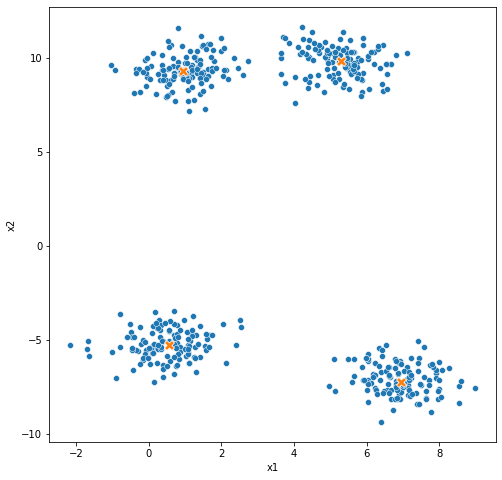

In [5]:
# tamano del grafico
fig = plt.figure(figsize=(8,8))
# grafico de los datos df_blobs
sns.scatterplot(data=df_blobs, x='x1', y='x2')
sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s=100)
plt.plot()
plt.show()

Visualizamos los datos de df_moons

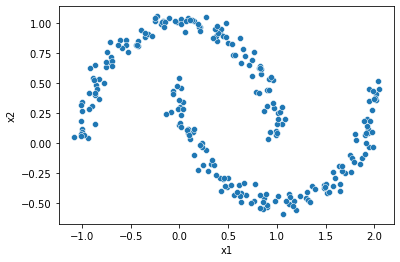

In [6]:
sns.scatterplot(data=df_moons, x='x1', y='x2')
plt.show()

> Aplicar K-Means en estos datos no funciona debido a que no presenta forma esferica

## Implementando DBSCAN

In [7]:
# definimos el modelo con sus respectivos parametros
dbscan_cluster = DBSCAN(eps=0.3, min_samples=3)

# generamos la prediccion con los datos de las medias lunas
y_m_predict = dbscan_cluster.fit_predict(X_m)

# agregamos las predicciones al dataframe d_moons
df_moons['cluster'] = y_m_predict

Visualizamos los datos de la media luna pero esta vez haciendo una segmentacion con la prediccion

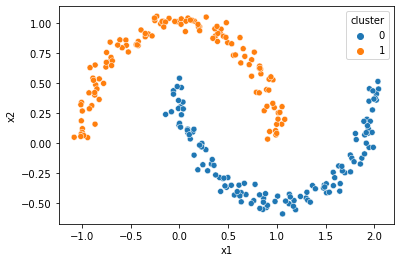

In [8]:
sns.scatterplot(data=df_moons, x='x1', y='x2', hue='cluster')
plt.show()

> El modelo logra separar los dos clusteres de manera correcta. La clave fue la eleccion correcta de los hiperparametros

Vamos a aplicar DBSCAN en los datos de df_blobs para ver como el algoritmo resuelve este tipo de problemas.

In [9]:
# definimos el modelo y sus respectivos hiperparametros
dbscan = DBSCAN(eps=1, min_samples=4)

# generamos la prediccion usando los datos esfericos
y_predict = dbscan.fit_predict(X)

# agregamos las predicciones al dataframe
df_blobs['cluster'] = y_predict

Visualizamos los datos esfericos pero esta vez con una segmentacion dada por las predicciones

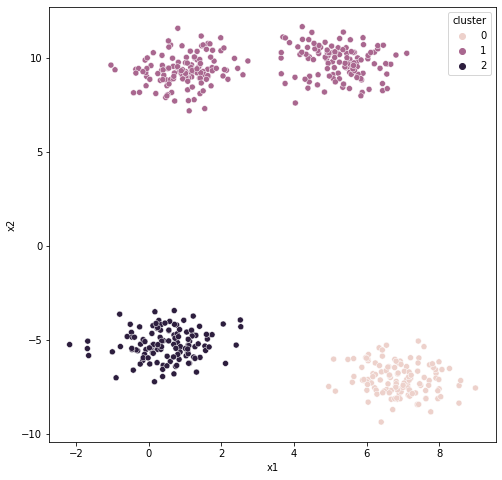

In [10]:
# tamano del grafico
fig = plt.figure(figsize=(8,8))
# grafico de los datos df_blobs
sns.scatterplot(data=df_blobs, x='x1', y='x2', hue='cluster')
plt.plot()
plt.show()

> El modelo logra identificar 3 clusteres. Une dos clusteres debido a que comparten puntos

> El cluster negativo indica el ruido que hay en los datos

## Hyperparameters

In [11]:
# importamos un estimador para ayudar a estimar un valor adecuado de eps
from sklearn.neighbors import NearestNeighbors

Para encontrar el valor optimo de _n_neighbord_ no hay formula magica, pero si podemos seguir la siguiente recomendacion: Se considera el numero de dimensiones de los puntos y se multiplica por 2.

En este caso, son 2 dimensiones, por tanto seria 4. Pero probemos con 3 ya que no es una ciencia exacta.

In [12]:
# encontrar los vecinos mas cercanos de cada punto
neighbors = NearestNeighbors(n_neighbors=3)

# entrenamos el estimador con los datos X
neighbors_fit = neighbors.fit(X)

# obtenemos las distancias a los vecinos mas cercanos y los indices de esos vecinos
distance, index = neighbors_fit.kneighbors(X)

In [13]:
# Cada punto presenta 3 vecinos mas cercanos que estan representados por sus distancias
distance

array([[0.        , 0.10282746, 0.13282713],
       [0.        , 0.03352035, 0.09129118],
       [0.        , 0.09292013, 0.12123273],
       ...,
       [0.        , 0.11915463, 0.19120257],
       [0.        , 0.53525778, 0.57908416],
       [0.        , 0.03891479, 0.36630112]])

A partir de las distancias calculadas anteriormente, podemos calcular el epsilon optimo. Para ello, vamos a graficar las distancias ordenadas pero esta vez solo los puntos con la distancia mas cercana.

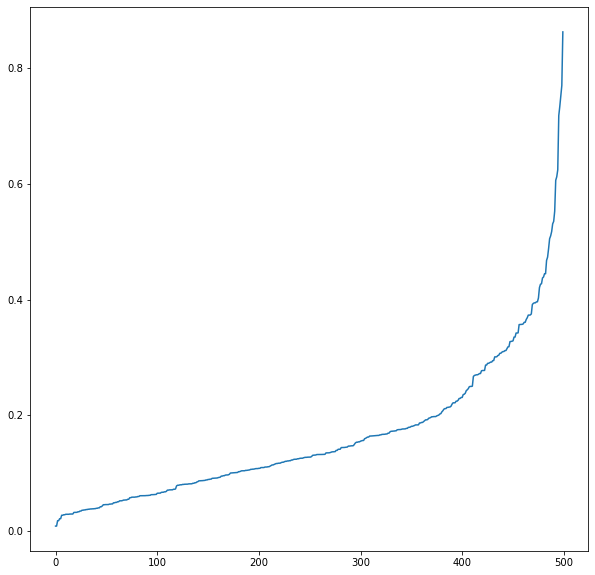

In [14]:
# ordenamos las distancias en cada columna
distances = np.sort(distance, axis=0)

# seleccionamos las distancias al segundo vecino mas cercano para cada punto
distances = distances[:,1]

# graficamos los puntos seleccionados para encontrar la rodilla
fig = plt.figure(figsize=(10,10))
plt.plot(distances)

- Seleccionamos al area de puntos donde inicia en ascenso rapido. En este caso indica los valores que estan entre 0.2 y 0.4. Estos son el rango de valores que se van a probar como epsilon optimo 

- Esta tecnica se conoce como la tecnica de la rodilla.

- Permite hacernos una idea del epsilon que debemos configurar. Ahora, con este valor, mas el valor del vecinos minimos, pasamos a configurar DBSCAN.

In [15]:
# crear arrays con valores posibles para los parametros eps y min_samples

# definimos el rango de epsilon a iterar
eps_values = np.arange(0.25, 0.8, 0.10)

# definimos el rango de vecinos mas cercanos a iterar
min_samples = np.arange(2,10)

In [16]:
print(eps_values)
print(min_samples)

[0.25 0.35 0.45 0.55 0.65 0.75]
[2 3 4 5 6 7 8 9]


Convertimos los valores a iterar en una matriz

In [17]:
from itertools import product

# lista con el producto de valores a iterar
dbscan_param = list(product(eps_values, min_samples))
dbscan_param

[(0.25, 2),
 (0.25, 3),
 (0.25, 4),
 (0.25, 5),
 (0.25, 6),
 (0.25, 7),
 (0.25, 8),
 (0.25, 9),
 (0.35, 2),
 (0.35, 3),
 (0.35, 4),
 (0.35, 5),
 (0.35, 6),
 (0.35, 7),
 (0.35, 8),
 (0.35, 9),
 (0.44999999999999996, 2),
 (0.44999999999999996, 3),
 (0.44999999999999996, 4),
 (0.44999999999999996, 5),
 (0.44999999999999996, 6),
 (0.44999999999999996, 7),
 (0.44999999999999996, 8),
 (0.44999999999999996, 9),
 (0.5499999999999999, 2),
 (0.5499999999999999, 3),
 (0.5499999999999999, 4),
 (0.5499999999999999, 5),
 (0.5499999999999999, 6),
 (0.5499999999999999, 7),
 (0.5499999999999999, 8),
 (0.5499999999999999, 9),
 (0.6499999999999999, 2),
 (0.6499999999999999, 3),
 (0.6499999999999999, 4),
 (0.6499999999999999, 5),
 (0.6499999999999999, 6),
 (0.6499999999999999, 7),
 (0.6499999999999999, 8),
 (0.6499999999999999, 9),
 (0.7499999999999999, 2),
 (0.7499999999999999, 3),
 (0.7499999999999999, 4),
 (0.7499999999999999, 5),
 (0.7499999999999999, 6),
 (0.7499999999999999, 7),
 (0.7499999999999999

Procedemos a ejecutar DBSCAN con todas las combinaciones.

In [18]:
# lista para almacenar el score de silueta
sil_scoure = []

for p in dbscan_param:
    y_pred = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(X)
    sil_scoure.append(silhouette_score(X, y_pred))

In [19]:
sil_scoure[:5]

[-0.1155182169920455,
 -0.12519143583033596,
 -0.15542982658100354,
 -0.2152704807908136,
 -0.32272822210989854]

Creamos un dataframe con las combinaciones de parametros y sus puntajes.

In [20]:
# dataframe con los hiperparametros
df_params_tunning = pd.DataFrame.from_records(dbscan_param, columns=['Eps', 'Min_Samples'])
df_params_tunning.head()

,Eps,Min_Samples
0,0.25,2
1,0.25,3
2,0.25,4
3,0.25,5
4,0.25,6


Agregamos al dataframe, los valores correspondiente de coeficiente de silueta

In [21]:
df_params_tunning['Sil_Scores'] = sil_scoure
df_params_tunning.head()

,Eps,Min_Samples,Sil_Scores
0,0.25,2,-0.115518
1,0.25,3,-0.125191
2,0.25,4,-0.155430
3,0.25,5,-0.215270
4,0.25,6,-0.322728


Convertimos el dataframe en una estructura matricial

In [22]:
pivot_data = pd.pivot_table(df_params_tunning, values='Sil_Scores', index='Min_Samples', columns='Eps')
pivot_data

Eps,0.25,0.35,0.45,0.55,0.65,0.75
Min_Samples,,,,,,
2,-0.115518,-0.056585,0.108093,0.347168,0.520056,0.720306
3,-0.125191,0.221156,0.562797,0.470437,0.632515,0.720306
4,-0.155430,0.143056,0.626974,0.598784,0.629132,0.720306
5,-0.215270,0.185187,0.583143,0.658734,0.693505,0.719169
6,-0.322728,0.183366,0.553376,0.648753,0.685579,0.715556
7,-0.416466,0.125321,0.489399,0.632754,0.685808,0.710515
8,-0.521541,0.012754,0.469667,0.600822,0.682186,0.701333
9,-0.577029,-0.051108,0.432846,0.577290,0.678821,0.691359


Graficamos los valores de silueta para cada combinacion de hiperparametro en un mapa de calor

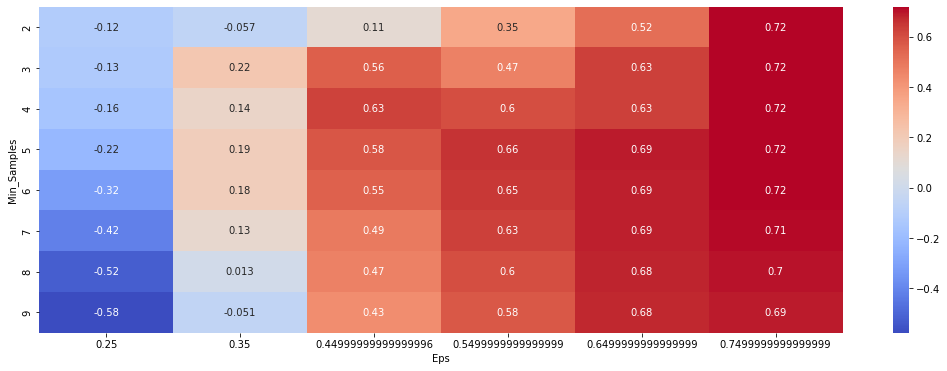

In [23]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_data, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

> El grafico nos muestra que la mejor combinacion de hiperparametros es dado por Eps=0.79 y Min_samples = 2. 

> Estos valores arrojan los mejores resultados

## Evaluación de DBSCAN

Vamos a ejecutar nuevamente DBSCAN pero esta vez, con los hiperparametros seleccionados como los mejores.

In [24]:
dbscan_cluster = DBSCAN(eps=0.79, min_samples=2)
y_predict = dbscan_cluster.fit_predict(X)
df_blobs['cluster'] = y_predict

Visualizamos loa clusteres que detecta DBSCAN en los datos

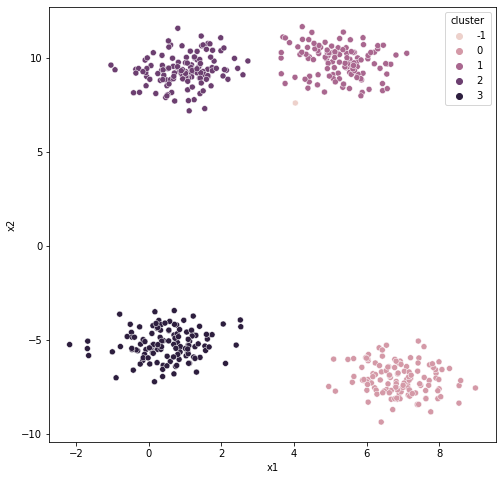

In [25]:
# tamano del grafico
fig = plt.figure(figsize=(8,8))
# grafico de los datos df_blobs
sns.scatterplot(data=df_blobs, x='x1', y='x2', hue='cluster')
plt.plot()
plt.show()

Analicemos el indice de silueta con el codigo dado por la libreria [sk-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

For n_clusters = 5 The average silhouette_score is : 0.6550317673600607


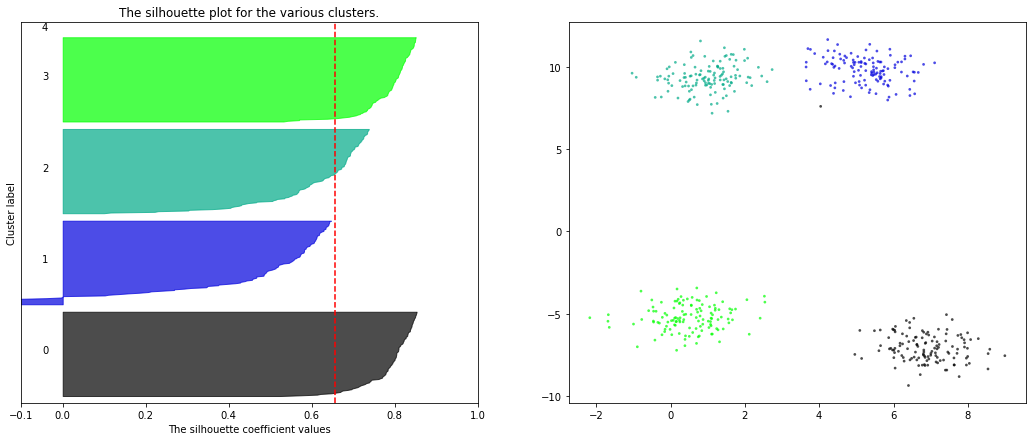

In [27]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score




# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])

clusterer = DBSCAN(eps=0.79, min_samples=2)
cluster_labels = clusterer.fit_predict(X)
n_clusters = len(np.unique(cluster_labels))

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

    # Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

        # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)


plt.show()

> La mayoría de los puntos tienen scores positivos, lo que indica que están bien agrupados.

> Algunos puntos en el clúster 1 tienen scores bajos o negativos → podrían estar mal asignados o estar en la frontera entre clústeres.

> El clustering ha funcionado bien: clústeres definidos y bien separados.

> El valor promedio del coeficiente de silhouette (~0.62) indica una buena cohesión y separación.

> Un par de clústeres tienen algunos puntos menos definidos, lo cual podría mejorarse ajustando parámetros o usando otro algoritmo.
